MULTIPLE SOURCE TESTS:

This code is meant to compare the resolution obtained through the comsol simulations without simplification of the source geometry (in 2D), and my own code.

The BCs in the COMSOL code are given as:
$$
-\mathbf{n}\cdot (- \nabla \phi) = g_c - q_c \phi
$$
where the subscript $c$ is meant to denominate the COMSOL coefficients, the $\mathbf{n}$ is the normal vector pointing OUTSIDE of the domain.

Therefore, for our case where I commonly work in terms of $q$:
$$q_0=C_0(<C_v> - \bar{\phi})$$

and $$C_0 = K_{eff} \pi R_v^2$$

Therefore, if we consider an axisymmetric vessel:
$$
\dfrac{C_0}{2 \pi R_v D} (<C_v> - \bar{\phi}) = g_c - q_c \phi \quad at \quad \partial \Omega_\beta
$$

For simplicity, let's consider $q_c=g_c=1$
So 
$$
C_0=2 \pi R_v D
$$

In [47]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append('/home/pdavid//Bureau/Code/SS/2D_cartesian/SS_code/FV_metab')
import numpy as np 
import matplotlib.pyplot as plt
from module_2D_coupling_FV_nogrid import * 
import reconst_and_test_module as post
import random 
import scipy as sp
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6,6 ),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

def get_plots_through_sources(phi_mat, SS_phi_mat,pos_s, rec_x,rec_y):
    for i in pos_s:
        pos=coord_to_pos(rec_x, rec_y, i)
        pos_x=int(pos%len(rec_x))
        plt.plot(rec_y, phi_mat[:,pos_x], label="coupling")
        plt.plot(rec_y, SS_phi_mat[:,pos_x], label="validation")
        plt.axvline(x=i[1])
        plt.legend()
        plt.show()
        
def get_plots_through_sources_peaceman(phi_mat,peaceman,pos_s, rec_x,rec_y):
    for i in pos_s:
        pos=coord_to_pos(rec_x, rec_y, i)
        pos_x=int(pos%len(rec_x))
        plt.plot(rec_y, phi_mat[:,pos_x], label="coupling")
        plt.scatter(rec_y, peaceman[:,pos_x], label="validation")
        plt.plot()
        plt.axvline(x=i[1])
        plt.legend()
        plt.show()

#0-Set up the sources
#1-Set up the domain
D=1
L=10
cells=10
h_ss=L/cells
#ratio=int(np.max((h_ss/0.1,6)))
ratio=12
#Rv=np.exp(-2*np.pi)*h_ss
Rv=0.1

a=2*Rv

C0=2*np.pi*Rv*D
K_eff=C0/(np.pi*Rv**2)

directness= 1


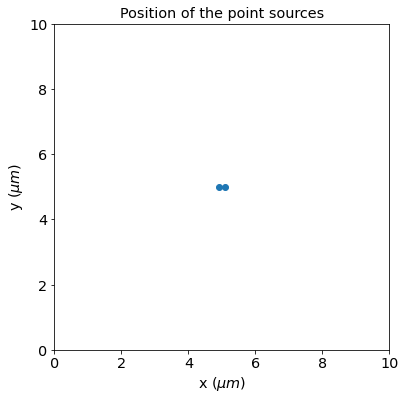

In [48]:
x_ss=np.linspace(h_ss/2, L-h_ss/2, int(np.around(L/h_ss)))
y_ss=x_ss
directness=1
print("directness=", directness)

pos_s=np.array([[0.5-a/(2*L), 0.5],[0.5+a/(2*L), 0.5]])*L
S=len(pos_s)
plt.scatter(pos_s[:,0], pos_s[:,1])
plt.title("Position of the point sources")
plt.ylim((0,L))
plt.xlim((0,L))
plt.ylabel("y ($\mu m$)")
plt.xlabel("x ($\mu m$)")
plt.show()

In [49]:
t=assemble_SS_2D_FD(pos_s, Rv, h_ss,L, K_eff, D, directness)
t.pos_arrays()
t.initialize_matrices()
M=t.assembly_sol_split_problem(np.array([0,0,0,0]))
t.B[-S:]=np.ones(S)
#t.B[-np.random.randint(0,S,int(S/2))]=0
sol=np.linalg.solve(M, t.B)
phi_FV=sol[:-S].reshape(len(t.x), len(t.y))
phi_q=sol[-S:]

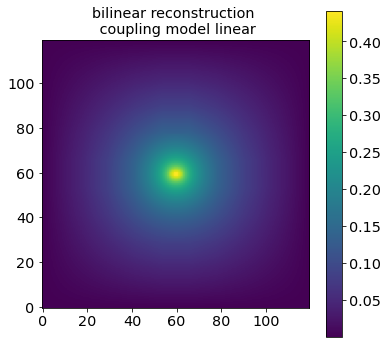

In [50]:
a=post.reconstruction_sans_flux(sol, t, L,ratio, directness)
p=a.reconstruction()   
a.reconstruction_boundaries(np.array([0,0,0,0]))
a.rec_corners()
plt.imshow(a.rec_final, origin='lower')
plt.title("bilinear reconstruction \n coupling model linear")
plt.colorbar(); plt.show()

In [51]:
array_of_sep=np.linspace(2,10,9)*Rv
q_array_source=np.zeros((0,2))
for a in array_of_sep:
    pos_s=np.array([[0.5-a/(2*L), 0.5],[0.5+a/(2*L), 0.5]])*L
    
    t=assemble_SS_2D_FD(pos_s, Rv, h_ss,L, K_eff, D, directness)
    t.pos_arrays()
    t.initialize_matrices()
    M=t.assembly_sol_split_problem(np.array([0,0,0,0]))
    t.B[-S:]=np.ones(S)
    #t.B[-np.random.randint(0,S,int(S/2))]=0
    sol=np.linalg.solve(M, t.B)
    phi_FV=sol[:-S].reshape(len(t.x), len(t.y))
    phi_q=sol[-S:]
    
    q_array_source=np.concatenate((q_array_source, np.array([phi_q])), axis=0)

In [52]:
q_COMSOL_sources=np.array([0.3542,0.3699,0.3774,0.383,0.3876,0.3915,0.3948,0.398,0.4007])


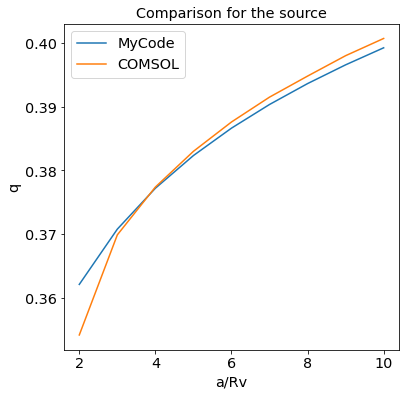

No handles with labels found to put in legend.


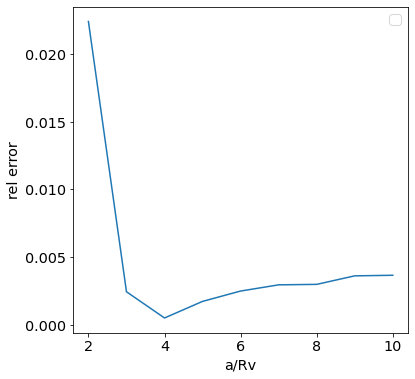

In [53]:
plt.plot(array_of_sep/Rv, q_array_source[:,1], label='MyCode')
plt.plot(array_of_sep/Rv, q_COMSOL_sources, label='COMSOL')
plt.legend()
plt.xlabel("a/Rv")
plt.ylabel("q")
plt.title("Comparison for the source")
plt.show()

plt.plot(array_of_sep/Rv,np.abs(q_array_source[:,1]-q_COMSOL_sources)/q_COMSOL_sources)
plt.legend()
plt.xlabel("a/Rv")
plt.ylabel("rel error")
plt.show()


In [54]:
array_of_sep=np.linspace(2,10,9)*Rv
q_array_sink=np.zeros((0,2))
for a in array_of_sep:
    pos_s=np.array([[0.5-a/(2*L), 0.5],[0.5+a/(2*L), 0.5]])*L
    
    t=assemble_SS_2D_FD(pos_s, Rv, h_ss,L, K_eff, D, directness)
    t.pos_arrays()
    t.initialize_matrices()
    M=t.assembly_sol_split_problem(np.array([0,0,0,0]))
    t.B[-S:]=np.ones(S)
    t.B[-1]= 0
    #t.B[-np.random.randint(0,S,int(S/2))]=0
    sol=np.linalg.solve(M, t.B)
    phi_FV=sol[:-S].reshape(len(t.x), len(t.y))
    phi_q=sol[-S:]
    
    q_array_sink=np.concatenate((q_array_sink, np.array([phi_q])), axis=0)

In [55]:
q_COMSOL_sink=np.array([[-0.1118,0.466],
                       [-0.096,0.4659],
                       [-0.086,0.4635],
                       [-0.0784,0.4615],
                       [-0.0722,0.4599],
                       [-0.067,0.4586],
                       [-0.0626,0.4575],
                      [-0.0587,0.4559],
                      [-0.0552,0.4559]])

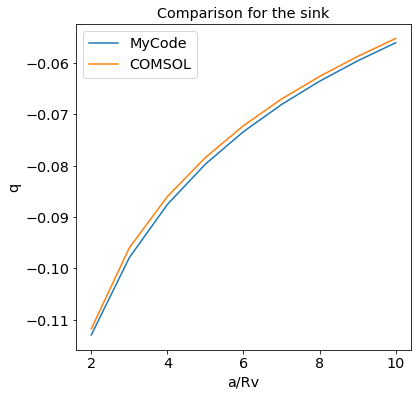

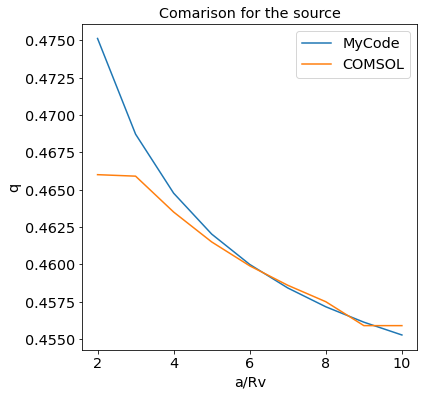

In [56]:
plt.plot(array_of_sep/Rv,q_array_sink[:,1], label='MyCode')
plt.plot(array_of_sep/Rv,q_COMSOL_sink[:,0], label='COMSOL')
plt.legend()
plt.xlabel("a/Rv")
plt.ylabel("q")
plt.title("Comparison for the sink")
plt.show()

plt.plot(array_of_sep/Rv,q_array_sink[:,0], label='MyCode')
plt.plot(array_of_sep/Rv,q_COMSOL_sink[:,1], label='COMSOL')
plt.xlabel("a/Rv")
plt.ylabel("q")
plt.legend()
plt.title("Comarison for the source")
plt.show()

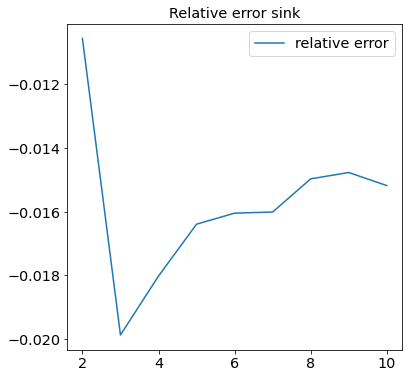

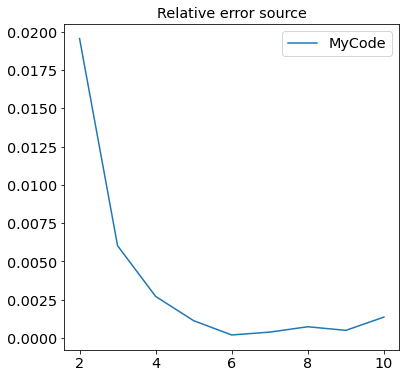

In [57]:
plt.plot(array_of_sep/Rv,np.abs(q_array_sink[:,1]-q_COMSOL_sink[:,0])/q_COMSOL_sink[:,0], label='relative error')
plt.legend()
plt.title("Relative error sink")
plt.show()

plt.plot(array_of_sep/Rv,np.abs(q_array_sink[:,0]-q_COMSOL_sink[:,1])/q_COMSOL_sink[:,1], label='MyCode')
plt.legend()
plt.title("Relative error source")
plt.show()